In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

In [3]:
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [4]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
# detect missing values
print(train_data.isnull().sum())
print("*" * 20)
print(test_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
********************
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# combine train and test data for data cleaning
train_features = train_data.drop(["Survived"], axis=1)
train_targets = train_data["Survived"]

combined = train_features.append(test_data)
combined.reset_index(inplace=True)
combined.shape

(1309, 12)

In [7]:
# Fill missing values in Age
fill_mean = lambda g: g.fillna(g.mean())
combined['Age'] = combined.groupby(['Sex', 'Pclass'])['Age'].apply(fill_mean)

In [8]:
# Fill missing values in Embarked
combined['Embarked'].fillna('S', inplace=True)

In [9]:
# Drop columns
combined.drop(["index", "PassengerId", "Name", "Ticket", "Fare", "Cabin"], inplace=True, axis=1)

In [10]:
# encoding in dummy variable
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop('Embarked', axis=1, inplace=True)

# mapping gender to numerical one 
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})

# introducing a new feature : the size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

In [19]:
train_new = combined.iloc[:891]
test_new = combined.iloc[891:]

In [20]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0, class_weight=None)
lr.fit(train_new,train_targets)

train_predict = lr.predict(train_new)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# Prediction on test set
test_predict = lr.predict(test_new)
test_data["Predict_Survived"] = test_predict
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predict_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0


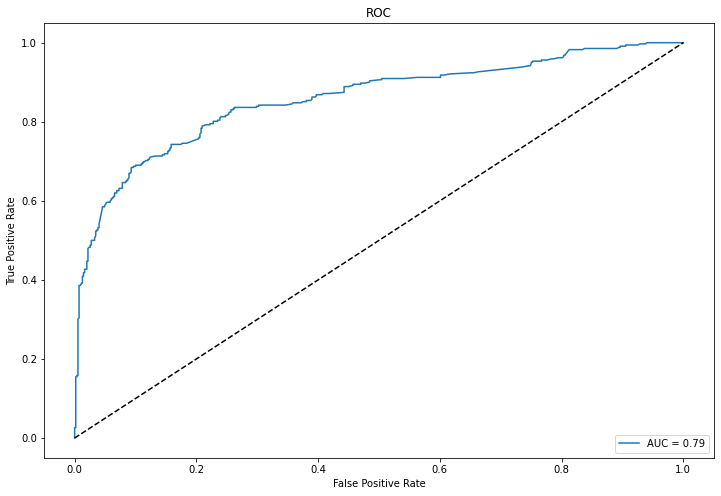

In [34]:
# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

preds_probabilities = lr.predict_proba(train_new)
pred_probs = preds_probabilities[:, 1]

roc_auc = roc_auc_score(train_targets, train_predict)
fpr, tpr, threshold = roc_curve(train_targets, pred_probs)

# ROC
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.title('ROC')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

print("accuracy: %2.3f" % accuracy_score(train_targets, train_predict))
conf_m=confusion_matrix(train_targets, train_predict)
print(conf_m)

accuracy: 0.813
[[481  68]
 [ 99 243]]
